<a href="https://colab.research.google.com/github/UgoRicher/ProjetTechnique/blob/main/Mod%C3%A8leProjetTechnique.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/100
5/5 [==============================] - 9s 596ms/step - loss: 0.0187 - val_loss: 0.0116
Epoch 2/100
5/5 [==============================] - 0s 70ms/step - loss: 0.0182 - val_loss: 0.0071
Epoch 3/100
5/5 [==============================] - 0s 78ms/step - loss: 0.0169 - val_loss: 0.0070
Epoch 4/100
5/5 [==============================] - 0s 75ms/step - loss: 0.0168 - val_loss: 0.0074
Epoch 5/100
5/5 [==============================] - 0s 78ms/step - loss: 0.0165 - val_loss: 0.0079
Epoch 6/100
5/5 [==============================] - 0s 69ms/step - loss: 0.0166 - val_loss: 0.0079
Epoch 7/100
5/5 [==============================] - 0s 41ms/step - loss: 0.0166 - val_loss: 0.0078
Epoch 8/100
5/5 [==============================] - 0s 46ms/step - loss: 0.0168 - val_loss: 0.0074
Epoch 9/100
5/5 [==============================] - 0s 48ms/step - loss: 0.0166 - val_loss: 0.0078
Epoch 10/100
5/5 [==============================] - 0s 45ms/step - loss: 0.0163 - val_loss: 0.0079
Epoch 11/100
5/5 [

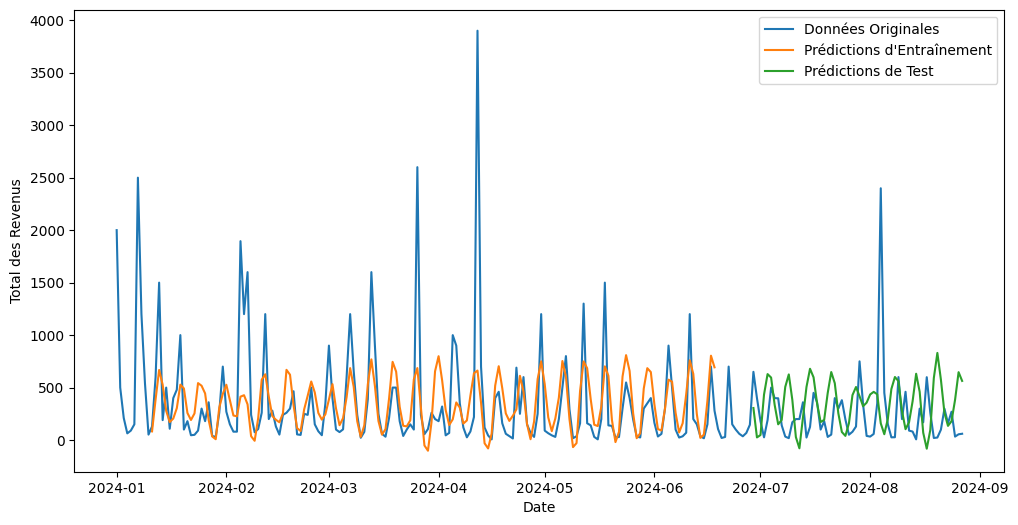

In [89]:
# Modèle de Prévision avec Réseaux de Neurones Récurents (RNN)

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# Chargement du dataset
file_path = '/content/Online Sales Data.csv'
data = pd.read_csv(file_path, sep=';')

# Remplissage des valeurs manquantes dans 'Total Revenue' par 0
data['Total Revenue'] = data['Total Revenue'].fillna(0)

# Conversion de la colonne 'Date' en datetime avec le format jour/mois/année et tri par date
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)
data = data.sort_values(by='Date')

# Sélection des colonnes pertinentes
df = data[['Date', 'Total Revenue']]

# Définition de la colonne 'Date' comme index
df.set_index('Date', inplace=True)

# Mise à l'échelle des données entre 0 et 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Préparation des données pour le LSTM
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 10
X, y = create_dataset(scaled_data, time_step)

# Reshape des données d'entrée pour être [samples, time steps, features] nécessaire pour le LSTM
X = X.reshape(X.shape[0], X.shape[1], 1)

# Division des données en ensembles d'entraînement et de test
train_size = int(len(X) * 0.7)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

# Création et entraînement du modèle LSTM
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Prédictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Transformation inverse pour revenir à l'échelle originale
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform([y_train])
y_test = scaler.inverse_transform([y_test])

# Vérification des tailles des prédictions
print("Taille des prédictions d'entraînement:", train_predict.shape)
print("Taille des prédictions de test:", test_predict.shape)

# Tracé des résultats
plt.figure(figsize=(12,6))
plt.plot(df.index, scaler.inverse_transform(scaled_data), label='Données Originales')

# Décalage des prédictions d'entraînement pour le tracé
train_plot = np.empty_like(scaled_data)
train_plot[:, :] = np.nan
train_plot[time_step:len(train_predict) + time_step, :] = train_predict

# Décalage des prédictions de test pour le tracé
test_plot = np.empty_like(scaled_data)
test_plot[:, :] = np.nan

# Ajout des prédictions de test dans test_plot
test_start_idx = len(train_predict) + (time_step * 2)
for i in range(len(test_predict)):
    if test_start_idx + i < len(test_plot):
        test_plot[test_start_idx + i, 0] = test_predict[i, 0]

plt.plot(df.index, train_plot, label='Prédictions d\'Entraînement')
plt.plot(df.index, test_plot, label='Prédictions de Test')
plt.xlabel('Date')
plt.ylabel('Total des Revenus')
plt.legend()
plt.show()






In [ ]:
# Variabilité des Données:

# Les revenus montrent une forte variabilité et des fluctuations importantes, ce qui peut rendre la prédiction difficile.
# Les pics élevés et les valeurs extrêmement basses peuvent être dus à des événements ou des promotions spécifiques.

# Lissage des Prédictions:

# Les prédictions du modèle sont plus lissées par rapport aux données originales.
#Cela indique que le modèle a du mal à prédire les fluctuations extrêmes et tend à généraliser les tendances.

# Performance sur les Données de Test:

# Bien que le modèle suive une tendance générale sur les données de test, il manque certains des changements brusques.
# Cela suggère que le modèle peut capturer les tendances à long terme, mais a des difficultés avec les variations à court terme.

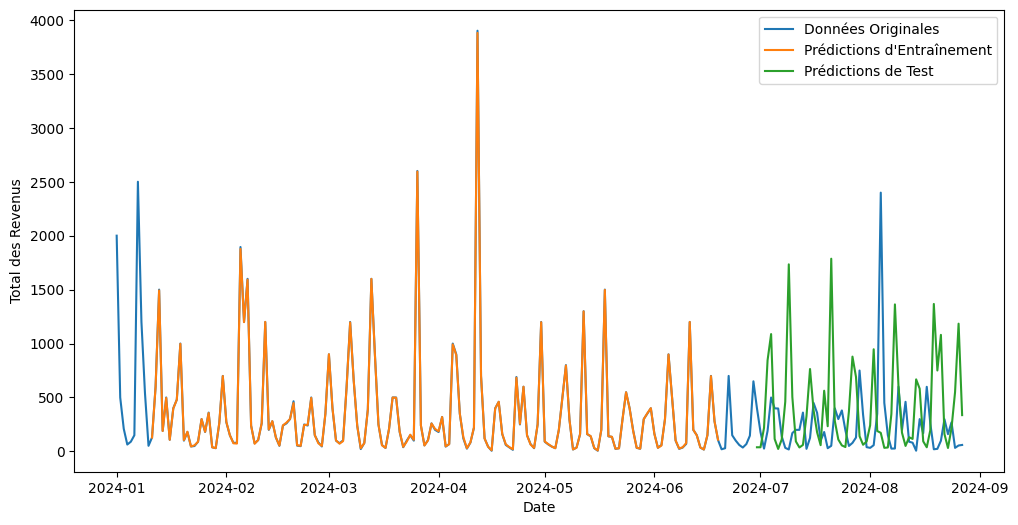

In [90]:
# Modèle de Prévision avec Arbres de Décision Boostés (XGBoost)

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# Chargement du dataset
file_path = '/content/Online Sales Data.csv'
data = pd.read_csv(file_path, sep=';')

# Remplissage des valeurs manquantes dans 'Total Revenue' par 0
data['Total Revenue'] = data['Total Revenue'].fillna(0)

# Conversion de la colonne 'Date' en datetime avec le format jour/mois/année et tri par date
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)
data = data.sort_values(by='Date')

# Sélection des colonnes pertinentes
df = data[['Date', 'Total Revenue']]

# Définition de la colonne 'Date' comme index
df.set_index('Date', inplace=True)

# Mise à l'échelle des données entre 0 et 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Préparation des données pour le modèle XGBoost
time_step = 10
X, y = [], []
for i in range(len(scaled_data) - time_step):
    X.append(scaled_data[i:(i + time_step), 0])
    y.append(scaled_data[i + time_step, 0])
X, y = np.array(X), np.array(y)

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Création et entraînement du modèle XGBoost
model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
model.fit(X_train, y_train)

# Prédictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Transformation inverse pour revenir à l'échelle originale
train_predict = scaler.inverse_transform(train_predict.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Tracé des résultats
plt.figure(figsize=(12,6))
plt.plot(df.index, scaler.inverse_transform(scaled_data), label='Données Originales')

# Décalage des prédictions d'entraînement pour le tracé
train_plot = np.empty_like(scaled_data)
train_plot[:, :] = np.nan
train_plot[time_step:len(train_predict) + time_step, :] = train_predict

# Décalage des prédictions de test pour le tracé
test_plot = np.empty_like(scaled_data)
test_plot[:, :] = np.nan
test_start_idx = len(train_predict) + (time_step * 2)
for i in range(len(test_predict)):
    if test_start_idx + i < len(test_plot):
        test_plot[test_start_idx + i, 0] = test_predict[i, 0]

plt.plot(df.index, train_plot, label='Prédictions d\'Entraînement')
plt.plot(df.index, test_plot, label='Prédictions de Test')
plt.xlabel('Date')
plt.ylabel('Total des Revenus')
plt.legend()
plt.show()


In [ ]:
# Performance:
# Le modèle XGBoost montre une bonne capacité à apprendre les motifs des données d'entraînement et à les reproduire.

# Généralisation:
# Sur les données de test, le modèle capture les tendances générales mais manque parfois la précision sur les variations rapides et les pics.

# A faire:
# Pour améliorer la précision, envisagez d'affiner les hyperparamètres, d'ajouter des caractéristiques supplémentaires,
# ou de combiner plusieurs modèles (ensemble learning).


# En résumé, le modèle est performant mais peut encore être amélioré pour mieux capturer les variations dans les données de test.